In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

### Import data

In [3]:
df_Ch001 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch001.pkl"))
df_Ch009 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch009.pkl"))
df_Ch020 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch020.pkl"))
df_Ch022 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch022.pkl"))

### preprocessing

In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df_input=[df_Ch001, df_Ch009, df_Ch020]
df_input_scaled=[]
LOG_SCALE= True

if LOG_SCALE:
    for df in df_input:

        df_log = df.copy()
        df_log = df_log.apply(lambda x: x.clip(lower=x[x>0].min()) if x.min()<=0 else x)
        df_log = df_log.apply(lambda x: np.log10(x))
        scaler=MinMaxScaler()
        scaler.fit(df_log)
        df_input_scaled.append(pd.DataFrame(scaler.transform(df_log), index=df_Ch022.index, columns=df_Ch022.columns))

    df_output_scaled=df_Ch022.copy()
    df_output_scaled= df_output_scaled.apply(lambda x: x.clip(lower=x[x>0].min()) if x.min()<=0 else x)
    df_output_scaled=df_output_scaled.apply(lambda x: np.log10(x))
    output_scaler=MinMaxScaler()
    output_scaler.fit(df_output_scaled)
    df_output_scaled[:]=output_scaler.transform(df_output_scaled)

else:
    for df in df_input:
        scaler=MinMaxScaler()
        scaler.fit(df)
        df_input_scaled.append(pd.DataFrame(scaler.transform(df), index=df_Ch022.index, columns=df_Ch022.columns))

        output_scaler=MinMaxScaler()
        output_scaler.fit(df_Ch022)
        df_output_scaled=pd.DataFrame(output_scaler.transform(df_Ch022), index=df_Ch022.index, columns=df_Ch022.columns)

1.890400    2.105000
1.972355    0.324000
2.057855    0.079333
2.147065    0.052667
2.240145    0.015500
2.337255    0.094500
2.438575    0.148400
2.544290    0.241667
2.654590    0.420667
2.769670    0.024500
2.889735    0.793500
3.015005    0.316000
3.145710    1.416000
3.282080    1.506000
3.424360    1.518500
3.572810    1.492000
3.727695    1.075650
3.889295    0.957400
4.057900    0.834150
4.233815    0.915100
4.417355    0.732900
4.608850    0.783000
4.808645    0.919750
5.017105    0.786950
5.234605    0.818200
5.461530    0.819250
5.698290    0.730000
5.945315    0.731200
6.203050    0.302500
6.471955    0.062500
6.752520    0.045000
7.045250    0.040500
7.350670    0.035500
7.669330    0.013000
8.001800    0.001000
dtype: float64
1.890400    194599.500000
1.972355    155499.500000
2.057855    132149.500000
2.147065     99499.500000
2.240145     84905.000000
2.337255     62033.333333
2.438575     14589.333333
2.544290     21896.666667
2.654590     17410.000000
2.769670     112

### Choosing L 

In [164]:
p=22

### plot intput scale

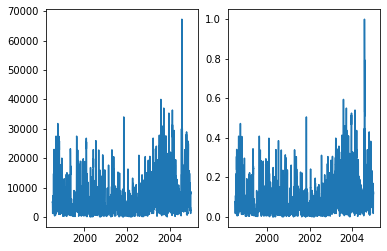

In [165]:
fig, (ax1, ax2)= plt.subplots(1,2)
ax1.plot(df_Ch022.index, df_input[2].iloc[:,p])
ax2.plot(df_Ch022.index, df_input_scaled[2].iloc[:,p])

### plot target scale

Text(0.5, 1.0, 'log_scale')

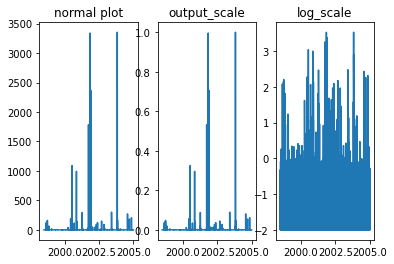

In [166]:
#log vs minmax
df_test=df_Ch022.copy()
df_test[df_test<=0 ] = 0.01
df_test = df_test.apply(lambda x: np.log10(x))
fig, (ax1, ax2, ax3)= plt.subplots(1,3)
ax1.plot(df_Ch022.index, df_Ch022.iloc[:,p])
ax1.set_title("normal plot")
ax2.plot(df_Ch022.index, df_output_scaled.iloc[:,p])
ax2.set_title("output_scale")
ax3.plot(df_Ch022.index, df_test.iloc[:,p])
ax3.set_title("log_scale")


### Split data

In [167]:
import torch
from sklearn.model_selection import train_test_split

In [168]:
split_data=int(len(df_Ch022.index)*0.9)

data_1=df_input_scaled[0].iloc[:split_data,p].values
data_2=df_input_scaled[1].iloc[:split_data,p].values
data_3=df_input_scaled[2].iloc[:split_data,p].values

data=np.vstack((data_1, data_2, data_3)).T

target=df_output_scaled.iloc[:,p].copy()
target=target.iloc[:split_data].values[:,np.newaxis]

In [169]:
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=20)
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()

In [170]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [171]:
trainset = TensorDataset(X_train, y_train)
train_loader = DataLoader(trainset, batch_size=3399)
validationset= TensorDataset(X_val, y_val)
val_loader = DataLoader(validationset, batch_size=850)

### ANN model

In [172]:
class ReLUNet(nn.Module):
    def __init__(self):
        super(ReLUNet, self).__init__()
        self.fc1 = nn.Linear(3, 40)
        self.fc2 = nn.Linear(40,1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Creating Model, Optimizer and Loss

In [173]:
# creating model,and defining optimizer and loss
model = ReLUNet()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

### Training and Evaluating using Ignite

In [174]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [175]:
# defining the number of epochs
epochs = 500
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'MSE':Loss(criterion)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'loss':[]}
validation_history = {'loss':[]}
last_epoch = []

In [176]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

In [177]:
def score_function(engine):
    val_loss = engine.state.metrics['MSE']
    return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [178]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    loss = metrics['MSE']
    last_epoch.append(0)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    loss = metrics['MSE']
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)  

### model save

In [179]:
checkpointer = ModelCheckpoint(Path('./saved_models'), 'ANN_v2_minmax', n_saved=1, create_dir=True, save_as_state_dict=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {str(p): model})

### Run Engine

In [180]:
trainer.run(train_loader, max_epochs=epochs)

ch: 288  Avg loss: 0.00
Validation Results - Epoch: 288  Avg loss: 0.00
Training Results - Epoch: 289  Avg loss: 0.00
Validation Results - Epoch: 289  Avg loss: 0.00
Training Results - Epoch: 290  Avg loss: 0.00
Validation Results - Epoch: 290  Avg loss: 0.00
Training Results - Epoch: 291  Avg loss: 0.00
Validation Results - Epoch: 291  Avg loss: 0.00
Training Results - Epoch: 292  Avg loss: 0.00
Validation Results - Epoch: 292  Avg loss: 0.00
Training Results - Epoch: 293  Avg loss: 0.00
Validation Results - Epoch: 293  Avg loss: 0.00
Training Results - Epoch: 294  Avg loss: 0.00
Validation Results - Epoch: 294  Avg loss: 0.00
Training Results - Epoch: 295  Avg loss: 0.00
Validation Results - Epoch: 295  Avg loss: 0.00
Training Results - Epoch: 296  Avg loss: 0.00
Validation Results - Epoch: 296  Avg loss: 0.00
Training Results - Epoch: 297  Avg loss: 0.00
Validation Results - Epoch: 297  Avg loss: 0.00
Training Results - Epoch: 298  Avg loss: 0.00
Validation Results - Epoch: 298  Avg

State:
	iteration: 500
	epoch: 500
	epoch_length: 1
	max_epochs: 500
	output: 0.00041802492341957986
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

### Plotting the loss and accuracy

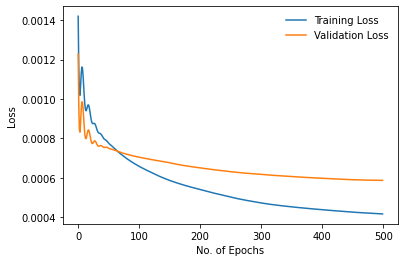

In [183]:
plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

### Loading the saved model from the disk

In [184]:
model.load_state_dict(torch.load(Path("C:/Users/Victor/Desktop/PIR/model/saved_models/ANN_v2_minmax_22_500.pt")))
print("Model Loaded")

Model Loaded


In [185]:
from sklearn.metrics import mean_squared_error

In [186]:
model.to("cpu")

data_1_test=df_input_scaled[0].iloc[:,p].values
data_2_test=df_input_scaled[1].iloc[:,p].values
data_3_test=df_input_scaled[2].iloc[:,p].values

data_test=np.vstack((data_1_test, data_2_test, data_3_test)).T
data_test=torch.tensor(data_test).float()
y_test=df_output_scaled.iloc[:, p].values

y_pred_test=model(data_test).detach().numpy()
MSE=mean_squared_error(y_test, y_pred_test)
print(MSE)

min=output_scaler.data_min_[p]
max=output_scaler.data_max_[p]
print(min, max)
y_pred_test=(max-min)*y_pred_test+min
if LOG_SCALE:
    y_pred_test=10 ** y_pred_test


0.00048032442790000283
-1.0 3353.0


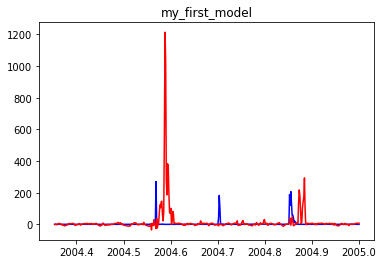

In [189]:
    plt.figure()
    plt.plot(df_Ch022.index[split_data:], df_Ch022.iloc[split_data:,p], color= "blue")
    # plt.plot(df_Ch022.index[split_data:], y_test[split_data:] )
    plt.plot(df_Ch022.index[split_data:], y_pred_test[split_data:], color="red")
    plt.title("my_first_model")

    plt.show()